In [1]:
# Import dependencies
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.metrics import classification_report_imbalanced
import psycopg2

In [2]:
# Connect to the Postgres db
try:
    connection = psycopg2.connect(user = "postgres",
                                  password = "f9dLM910&%S%",
                                  host = "dataviz.clw759vfh14c.us-east-2.rds.amazonaws.com",
                                  port = "5432",
                                  database = "my_data_class_db")

    cursor = connection.cursor()
    # Print PostgreSQL Connection properties
    print ( connection.get_dsn_parameters(),"\n")

    # Print PostgreSQL version
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record,"\n")

except (Exception, psycopg2.Error) as error :
    print ("Error while connecting to PostgreSQL", error)

{'user': 'postgres', 'dbname': 'my_data_class_db', 'host': 'dataviz.clw759vfh14c.us-east-2.rds.amazonaws.com', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'gssencmode': 'prefer', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

You are connected to -  ('PostgreSQL 11.6 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.3 20140911 (Red Hat 4.8.3-9), 64-bit',) 



In [3]:
# Test country table
postgreSQL_select_Query = "select * from country where country = 'GBR'"

cursor.execute(postgreSQL_select_Query)
print("Selecting rows from country using cursor.fetchall")
country_sample = cursor.fetchall() 
country_sample

Selecting rows from country using cursor.fetchall


[('GBR', 'United Kingdom of Great Britain and Northern Ireland (the)', 42526)]

In [4]:
# Identify hotel_bookings table schema and identify columns for easy entry when joining
postgreSQL_select_Query = "select column_name from INFORMATION_SCHEMA.COLUMNS where TABLE_NAME = 'hotel_bookings'"
cursor.execute(postgreSQL_select_Query)
print("Selecting column names using cursor.fetchall")
hb_colnames = cursor.fetchall() 
for col in hb_colnames:
    print(col)

Selecting column names using cursor.fetchall
('id',)
('hotel',)
('is_canceled',)
('lead_time',)
('arrival_date_year',)
('arrival_date_month',)
('arrival_date_week_number',)
('arrival_date_day_of_month',)
('stays_in_weekend_nights',)
('stays_in_week_nights',)
('adults',)
('children',)
('babies',)
('meal',)
('country',)
('market_segment',)
('distribution_channel',)
('is_repeated_guest',)
('previous_cancellations',)
('previous_bookings_not_canceled',)
('reserved_room_type',)
('assigned_room_type',)
('booking_changes',)
('deposit_type',)
('agent',)
('company',)
('days_in_waiting_list',)
('customer_type',)
('adr',)
('required_car_parking_spaces',)
('total_of_special_requests',)
('reservation_status',)
('reservation_status_date',)


In [7]:
# Reset postgres to avoid postgres error for previous queries that were run incorrectly
cursor.execute("rollback")

# Execute an inner join from two tables
postgreSQL_select_Query = "select * from hotel_bookings full outer join country on hotel_bookings.country=country.country"
cursor.execute(postgreSQL_select_Query)
print("Creating FULL OUTER JOIN using cursor.fetchall")
hotel_bookings_full = cursor.fetchall() 
hotel_bookings = pd.DataFrame(hotel_bookings_full, columns=['id','hotel','is_canceled','lead_time', 'arrival_date_year','arrival_date_month', 'arrival_date_week_number','arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled','reserved_room_type', 'assigned_room_type','booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date', 'country', 'country_name', 'GDP'])


Creating FULL OUTER JOIN using cursor.fetchall


In [8]:
# Look at the joined tables
hotel_bookings.head()

,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,country,country_name,GDP
0,1.0,Resort Hotel,False,342.0,2015.0,July,27.0,1.0,0.0,0.0,...,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01,PRT,Portugal,23478.0
1,2.0,Resort Hotel,False,737.0,2015.0,July,27.0,1.0,0.0,0.0,...,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01,PRT,Portugal,23478.0
2,3.0,Resort Hotel,False,7.0,2015.0,July,27.0,1.0,0.0,1.0,...,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02,GBR,United Kingdom of Great Britain and Northern I...,42526.0
3,4.0,Resort Hotel,False,13.0,2015.0,July,27.0,1.0,0.0,1.0,...,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02,GBR,United Kingdom of Great Britain and Northern I...,42526.0
4,5.0,Resort Hotel,False,14.0,2015.0,July,27.0,1.0,0.0,2.0,...,0.0,Transient,98.0,0.0,1.0,Check-Out,2015-07-03,GBR,United Kingdom of Great Britain and Northern I...,42526.0


## Is-canceled feature explanation
Value indicating if the booking was canceled (1) or not (0)

In [9]:
# Describe the shape
hotel_bookings.shape

(119392, 36)

In [10]:
# Print all column headers
for col in hotel_bookings:
    print(col)

id
hotel
is_canceled
lead_time
arrival_date_year
arrival_date_month
arrival_date_week_number
arrival_date_day_of_month
stays_in_weekend_nights
stays_in_week_nights
adults
children
babies
meal
country
market_segment
distribution_channel
is_repeated_guest
previous_cancellations
previous_bookings_not_canceled
reserved_room_type
assigned_room_type
booking_changes
deposit_type
agent
company
days_in_waiting_list
customer_type
adr
required_car_parking_spaces
total_of_special_requests
reservation_status
reservation_status_date
country
country_name
GDP


In [11]:
# Show the top ten records
hotel_bookings.head(10)

,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,country,country_name,GDP
0,1.0,Resort Hotel,False,342.0,2015.0,July,27.0,1.0,0.0,0.0,...,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01,PRT,Portugal,23478.0
1,2.0,Resort Hotel,False,737.0,2015.0,July,27.0,1.0,0.0,0.0,...,0.0,Transient,0.0,0.0,0.0,Check-Out,2015-07-01,PRT,Portugal,23478.0
2,3.0,Resort Hotel,False,7.0,2015.0,July,27.0,1.0,0.0,1.0,...,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02,GBR,United Kingdom of Great Britain and Northern I...,42526.0
3,4.0,Resort Hotel,False,13.0,2015.0,July,27.0,1.0,0.0,1.0,...,0.0,Transient,75.0,0.0,0.0,Check-Out,2015-07-02,GBR,United Kingdom of Great Britain and Northern I...,42526.0
4,5.0,Resort Hotel,False,14.0,2015.0,July,27.0,1.0,0.0,2.0,...,0.0,Transient,98.0,0.0,1.0,Check-Out,2015-07-03,GBR,United Kingdom of Great Britain and Northern I...,42526.0
5,6.0,Resort Hotel,False,14.0,2015.0,July,27.0,1.0,0.0,2.0,...,0.0,Transient,98.0,0.0,1.0,Check-Out,2015-07-03,GBR,United Kingdom of Great Britain and Northern I...,42526.0
6,7.0,Resort Hotel,False,0.0,2015.0,July,27.0,1.0,0.0,2.0,...,0.0,Transient,107.0,0.0,0.0,Check-Out,2015-07-03,PRT,Portugal,23478.0
7,8.0,Resort Hotel,False,9.0,2015.0,July,27.0,1.0,0.0,2.0,...,0.0,Transient,103.0,0.0,1.0,Check-Out,2015-07-03,PRT,Portugal,23478.0
8,9.0,Resort Hotel,True,85.0,2015.0,July,27.0,1.0,0.0,3.0,...,0.0,Transient,82.0,0.0,1.0,Canceled,2015-05-06,PRT,Portugal,23478.0
9,10.0,Resort Hotel,True,75.0,2015.0,July,27.0,1.0,0.0,3.0,...,0.0,Transient,105.5,0.0,0.0,Canceled,2015-04-22,PRT,Portugal,23478.0


In [12]:
# Remove one of the duplicate "country" columns
hotel_bookings = hotel_bookings.loc[:,~hotel_bookings.T.duplicated(keep='first')]

In [13]:
# Do some EDA (Exploratory Data Analysis) on the number of cancellations
cancelled_bookings = hotel_bookings["is_canceled"].isin([1]).sum()

In [14]:
# Do some EDA (Exploratory Data Analysis) on the number of non-cancellations
succesful_bookings = hotel_bookings["is_canceled"].isin([0]).sum()

In [20]:
# Compute for percentage of cancellations
pct_cancellation = ((cancelled_bookings)/(cancelled_bookings+succesful_bookings))*100
print('Percentage of Bookings Cancelled:'"{:.2f}".format(pct_cancellation)+'%')

Percentage of Bookings Cancelled:37.04%


## Result
There is an approximate cancellation rate of 37%

In [57]:
# Get info on dataframe, such as non-null counts and dtypes
hotel_bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118899 entries, 0 to 118898
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              118899 non-null  int64  
 1   hotel                           118899 non-null  object 
 2   is_canceled                     118899 non-null  bool   
 3   lead_time                       118899 non-null  int64  
 4   arrival_date_year               118899 non-null  int64  
 5   arrival_date_month              118899 non-null  object 
 6   arrival_date_week_number        118899 non-null  int64  
 7   arrival_date_day_of_month       118899 non-null  int64  
 8   stays_in_weekend_nights         118899 non-null  int64  
 9   stays_in_week_nights            118899 non-null  int64  
 10  adults                          118899 non-null  int64  
 11  children                        118895 non-null  float64
 12  babies          

In [58]:
# Get descriptions for all features
hotel_bookings.describe().T

,count,mean,std,min,25%,50%,75%,max
id,118899.0,59872.553596,34418.242521,1.00,30186.5,59929.0,89663.5,119390.0
lead_time,118899.0,104.306058,106.900775,0.00,18.0,69.0,161.0,737.0
arrival_date_year,118899.0,2016.157621,0.707476,2015.00,2016.0,2016.0,2017.0,2017.0
arrival_date_week_number,118899.0,27.166629,13.589786,1.00,16.0,28.0,38.0,53.0
arrival_date_day_of_month,118899.0,15.800486,8.780293,1.00,8.0,16.0,23.0,31.0
stays_in_weekend_nights,118899.0,0.928889,0.996215,0.00,0.0,1.0,2.0,16.0
stays_in_week_nights,118899.0,2.502157,1.900182,0.00,1.0,2.0,3.0,41.0
adults,118899.0,1.858409,0.578577,0.00,2.0,2.0,2.0,55.0
children,118895.0,0.104210,0.399177,0.00,0.0,0.0,0.0,10.0
babies,118899.0,0.007948,0.097380,0.00,0.0,0.0,0.0,10.0


In [59]:
# Make a copy of the dataset 
df = hotel_bookings.copy()

## Preprocessing 

In [60]:
# Find out if there are any missing Values
df.isnull().sum()

id                                     0
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                                0
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent           

There are three columns with missing values: 1) company, 2) agent, 3) country, 4) children. Of the three company has the most missing values almost 94.30% are missing, agent has 13.69% missing and country 0.41% missing. __NOTE:__We will drop the company and agent columns but we will keep the country column because this is part of the question we want to ask later. For the children column we will fill with 0 because this is the most common response for this column.

In [61]:
# Drop company column
df = df.drop(['company'], axis=1)

In [62]:
# Drop agent column
df = df.drop(['agent'], axis=1)

In [63]:
# We are assuming that those who did not have data for children don't have children
df['children'] = df['children'].fillna(0)

## Analyze variables (columns) and remove unnecessary variables (columns)

In [64]:
# Get the data types
df.dtypes

id                                  int64
hotel                              object
is_canceled                          bool
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                      

In [65]:
# Change values for Resort Hotel and City Hotel to numerical
df['hotel'] = df['hotel'].map({'Resort Hotel':0, 'City Hotel':1})

In [66]:
# Looking at the reservation_status column
df.reservation_status.unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

In [67]:
# Count the uniques
df.reservation_status.nunique()

3

In [68]:
# Check the number of responses in the is_canceled column
df['is_canceled'].value_counts()

False    74742
True     44157
Name: is_canceled, dtype: int64

__NOTE:__ The columns is_canceled and reservation_status are virtually identical, this will result in almost 100% prediction but this will be misleading __so__ we will drop the 'reservation_status' column.

In [69]:
# Drop 'reservation_status' column
df = df.drop(['reservation_status'], axis=1)

In [70]:
# Drop 'reservation_status_date' column
df = df.drop(['reservation_status_date'], axis=1)

In [71]:
# Delete the NA rows of country column
indices = df.loc[pd.isna(df["country"]), :].index 
df = df.drop(df.index[indices])   
df.isnull().sum()

id                                0
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

In [72]:
# Look at correlation to see which data has a relationship with cancelation
df.corr()

,id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,GDP
id,1.000000,0.816617,-0.246245,0.003088,0.298826,-0.054282,0.009147,-0.150124,-0.208211,-0.014607,...,-0.027917,-0.018970,-0.018163,0.004718,-0.006736,-0.015395,0.144116,-0.129119,0.105468,0.115637
hotel,0.816617,1.000000,0.134006,0.071832,0.033729,0.000734,-0.002136,-0.189733,-0.237761,-0.017748,...,-0.043669,-0.051350,-0.012333,0.000747,-0.073170,0.072014,0.093118,-0.217405,-0.043971,-0.003914
is_canceled,-0.246245,0.134006,1.000000,0.291966,0.016335,0.007487,-0.006166,-0.002638,0.024095,0.058403,...,-0.032525,-0.085189,0.109913,-0.055498,-0.144668,0.054006,0.046134,-0.194808,-0.235612,-0.209280
lead_time,0.003088,0.071832,0.291966,1.000000,0.039946,0.126728,0.002394,0.084019,0.164794,0.116773,...,-0.021145,-0.125085,0.085967,-0.071125,0.000021,0.170017,-0.066338,-0.115550,-0.096551,0.027293
arrival_date_year,0.298826,0.033729,0.016335,0.039946,1.000000,-0.540484,-0.000504,0.021691,0.031751,0.029086,...,-0.013179,0.010137,-0.119914,0.029804,0.031161,-0.056815,0.197912,-0.012648,0.108872,0.121185
arrival_date_week_number,-0.054282,0.000734,0.007487,0.126728,-0.540484,1.000000,0.066825,0.017646,0.015015,0.025423,...,0.010039,-0.030413,0.035367,-0.020769,0.005165,0.022993,0.075268,0.001716,0.025794,-0.007857
arrival_date_day_of_month,0.009147,-0.002136,-0.006166,0.002394,-0.000504,0.066825,1.000000,-0.015930,-0.027584,-0.001854,...,-0.000536,-0.006332,-0.027009,0.000122,0.010772,0.022743,0.029983,0.008274,0.003057,-0.005852
stays_in_weekend_nights,-0.150124,-0.189733,-0.002638,0.084019,0.021691,0.017646,-0.015930,1.000000,0.494896,0.090394,...,0.018397,-0.087834,-0.013007,-0.040596,0.062403,-0.054567,0.047318,-0.018144,0.071656,0.107546
stays_in_week_nights,-0.208211,-0.237761,0.024095,0.164794,0.031751,0.015015,-0.027584,0.494896,1.000000,0.091984,...,0.020157,-0.097994,-0.014274,-0.047367,0.095672,-0.002162,0.063644,-0.024379,0.066770,0.113326
adults,-0.014607,-0.017748,0.058403,0.116773,0.029086,0.025423,-0.001854,0.090394,0.091984,1.000000,...,0.017884,-0.147499,-0.006977,-0.105030,-0.052412,-0.008769,0.227424,0.016362,0.121840,0.070516


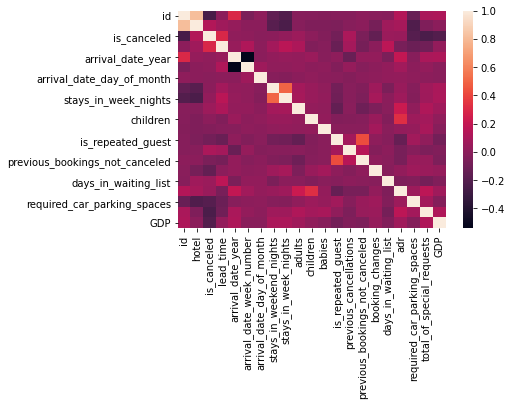

In [73]:
# Create a heatmap of the correlations
sns.heatmap(df.corr())

In [74]:
# Drop 'arrival_date_year' column
df = df.drop(['arrival_date_year'], axis=1)

In [75]:
# Sort the is_canceled values
df.corr()['is_canceled'].sort_values()

id                               -0.246245
total_of_special_requests        -0.235612
GDP                              -0.209280
required_car_parking_spaces      -0.194808
booking_changes                  -0.144668
is_repeated_guest                -0.085189
previous_bookings_not_canceled   -0.055498
babies                           -0.032525
arrival_date_day_of_month        -0.006166
stays_in_weekend_nights          -0.002638
children                          0.004735
arrival_date_week_number          0.007487
stays_in_week_nights              0.024095
adr                               0.046134
days_in_waiting_list              0.054006
adults                            0.058403
previous_cancellations            0.109913
hotel                             0.134006
lead_time                         0.291966
is_canceled                       1.000000
Name: is_canceled, dtype: float64

In [76]:
# Use get_dummies to translate features into numberical data
df = pd.get_dummies(data = df, drop_first=True, columns = ['arrival_date_month', 'meal', 'market_segment', 'deposit_type', 'distribution_channel', 'country',
                                            'reserved_room_type', 'assigned_room_type', 'customer_type', 'country_name'])



## Split the data into training and testing

In [77]:
# Create our features
X = df.drop(["is_canceled"], axis=1)

# Create our target
y = df["is_canceled"]

# Create X_train, X_test, y_train, and y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state =42, stratify=y)

In [78]:
# Create a variable for Standard Scaler
data_scaler = StandardScaler()

In [79]:
# Create new variable
X_train = data_scaler.fit_transform(X_train)

In [80]:
# Create new variable
X_test = data_scaler.transform(X_test)

## Decision Tree Model

In [81]:
# Create a baseline variable for DecisionTreeClassifier
baseline = DecisionTreeClassifier(max_depth = 12)

In [82]:
# Fit the baseline model with both training sets
baseline_model = baseline.fit(X_train, y_train)

In [83]:
# Create a prediction variable for X_test
y_pred = baseline_model.predict(X_test)

In [84]:
# (1)
# Run the Decision Tree model
print('Decision Tree Model')

print('Accuracy Score: {}\n\nConfusion Matrix:\n {}\n\nAUC Score: {}'
      .format(accuracy_score(y_test,y_pred), confusion_matrix(y_test,y_pred), roc_auc_score(y_test,y_pred)))

Decision Tree Model
Accuracy Score: 0.9754976170451359

Confusion Matrix:
 [[21916   507]
 [  367 12880]]

AUC Score: 0.9748424509430849


In [85]:
# Print the imbalanced classification report for Decision Tree
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.98      0.98      0.97      0.98      0.97      0.95     22423
       True       0.96      0.97      0.98      0.97      0.97      0.95     13247

avg / total       0.98      0.98      0.97      0.98      0.97      0.95     35670



In [87]:
# Define a function for the different models
def model(algorithm, X_train, X_test, y_train, y_test):
    alg = algorithm
    alg_model = alg.fit(X_train, y_train)
    global y_prob, y_pred
    y_prob = alg.predict_proba(X_test)[:,1]
    y_pred = alg_model.predict(X_test)

    print('Accuracy Score: {}\n\nConfusion Matrix:\n {}'
      .format(accuracy_score(y_test,y_pred), confusion_matrix(y_test,y_pred)))

In [88]:
# (2)
#Run Logistic Regression model
print('Model: Logistic Regression\n')
model(LogisticRegression(solver = "liblinear"), X_train, X_test, y_train, y_test)

Model: Logistic Regression

Accuracy Score: 0.9245584524810765

Confusion Matrix:
 [[20985  1438]
 [ 1253 11994]]


In [89]:
# Print the imbalanced classification report for Logistic Regression
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.94      0.94      0.91      0.94      0.92      0.85     22423
       True       0.89      0.91      0.94      0.90      0.92      0.84     13247

avg / total       0.92      0.92      0.92      0.92      0.92      0.85     35670



In [90]:
# (3) 
# Run Random Forest model
print('Model: Random Forest\n')
model(RandomForestClassifier(), X_train, X_test, y_train, y_test)

Model: Random Forest

Accuracy Score: 0.975834034202411

Confusion Matrix:
 [[22093   330]
 [  532 12715]]


In [76]:
# Print the imbalanced classification report for Random Forest
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.94      0.78      0.91      0.86      0.75     22424
          1       0.89      0.78      0.94      0.83      0.86      0.73     13247

avg / total       0.88      0.88      0.84      0.88      0.86      0.74     35671



In [92]:
# (4) 
# Run ADA boost model
print('Model: ADA Boost\n')
model(EasyEnsembleClassifier(), X_train, X_test, y_train, y_test)

Model: ADA Boost

Accuracy Score: 0.9629380431735352

Confusion Matrix:
 [[21495   928]
 [  394 12853]]


In [93]:
# Print the imbalanced classification report for ADA Boost model
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.98      0.96      0.97      0.97      0.96      0.93     22423
       True       0.93      0.97      0.96      0.95      0.96      0.93     13247

avg / total       0.96      0.96      0.97      0.96      0.96      0.93     35670



In [94]:
# Close Postgres connection
try:
    connection = psycopg2.connect(user = "postgres",
                                  password = "f9dLM910&%S%",
                                  host = "dataviz.clw759vfh14c.us-east-2.rds.amazonaws.com",
                                  port = "5432",
                                  database = "my_data_class_db")

finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

PostgreSQL connection is closed


## Should we lean into accuracy, precision, or sensitivity?  

There are multiple ways of assessing which model is preferred.  One of the things we need to decide on is whether accuracy, precision, or recall/sensitivity is most important given the nature of our data set?

Based on the definition of all three scores, here's what we think:

Accuracy = TP + TN / FP + FN
- Is it more important to be accurate in predictions of all bookings?  Random forest is the most accurate, predicting 89% of cancellations

Precision = TP/(TP + FP) 
- How good is this model at predicting that a booking will be canceled?? Random forest is the most precise, precisely predicting 89% of cancellations

Sensitivity = TP/(TP + FN) 
- How good is this model at catching all of the cancellations??  Random forest is the best, catching 89% of cancellations

## Which model is most relevant to this data set?

Prior to adding data for country table (which contains GDP data), the highest accuracy score we could get out of our models was around 89%.  After we added the GDP data as a feature, all models increased in accuracy, precision, etc.

We will likely go with the model that has the best accuracy (as well as sensitivity & precision), which is the Decision Tree Model.

## How can these findings help hotels from a practical/real world perspective?

Hotels that have insights and the ability to predict cancellations will be able to do a better job overall at many things, some of which would be:
- Predict monthly cash flows
- Hire and pay the right amount of staff
- Hotels will sometimes overbook rooms due to uncertainty around cancellations, so if they can predict that better, then they can create a better experience for customers by decreasing the chance that they'll double book and have to turn down a customer due to lack of available rooms